In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import glob
import numpy as np
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model

plt.rcParams['figure.figsize'] = [5, 5]

Using TensorFlow backend.


In [2]:
def deform(array, factor, axis):
    stretched = np.repeat(array, np.ceil(factor), axis=axis)
    indices = np.linspace(0, stretched.shape[axis] - 1, int(array.shape[axis] * factor))
    indices = np.rint(indices).astype(int)
    return np.take(stretched, indices, axis=axis)


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice(y_pred, y_true):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_loss(y_true, y_pred):
    return 1-dice(y_true, y_pred)

def weighted_categorical_crossentropy(y_true, y_pred):    
    #weights = K.variable([0.5,2.0,0.0])
    weights = K.variable([0.5,4.0,0.0])
        
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

def cat_dice_loss(y_true, y_pred):
#    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    #return weighted_categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)+fbeta_loss(y_true, y_pred)
    return weighted_categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    #return weighted_categorical_crossentropy(y_true, y_pred) +fbeta_loss(y_true, y_pred)
    #return dice_loss(y_true, y_pred)
    
def focal_loss(gamma=2, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):#with tensorflow
        eps = 1e-12
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        y_pred_f = K.clip(y_pred_f,eps,1.-eps)#improve the stability of the focal loss and see issues 1 for more information
        pt_1 = tf.where(tf.equal(y_true_f, 1), y_pred_f, tf.ones_like(y_pred_f))
        pt_0 = tf.where(tf.equal(y_true_f, 0), y_pred_f, tf.zeros_like(y_pred_f))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [3]:
K.set_image_data_format('channels_last')

data_path = './'
project_name = '3D-Unet'
img_depth = 16
img_rows = 32
img_cols = 32
smooth = 1.

In [4]:
def get_unet():
    inputs = Input((img_depth, img_rows, img_cols, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=2*1e-5), loss=dice_loss, metrics=[dice])

    return model

In [5]:
def train(video, mask):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    weight_dir = 'weights2'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), monitor='val_loss', save_best_only=True)

    log_dir = 'logs2'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    history = model.fit(video, mask, batch_size=32, epochs=70, verbose=1, shuffle=True, validation_split=0.1, callbacks=[model_checkpoint, csv_logger])
    
    print(history.history.keys())
    
    print('-'*30)
    print('Training finished')
    print('-'*30)
    
    # predicting in training function for rapid prototyping

In [ ]:
f2 =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/64_Patches/v024**')

L = []

for f in f2:
    if 'flip' in f:
        pass
    else:
        L.append(f)
        

f1 =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/64_Patches/v135**')

for f in f1:
    if 'flip' in f:
        pass
    else:
        L.append(f)

In [11]:
from random import shuffle

shuffle(L)

In [12]:
k = len(L)

nodules = np.zeros((k,64,64,16))
scans = np.zeros((k,64,64,16))

for i in range(k):
    scans[i,:,:,:] = np.load(L[i])['arr_0']
    
for i in range(k):
    nodules[i,:,:,:] = np.load(L[i].split('Patches')[0]+'Pseg'+L[i].split('Patches')[1])['arr_0']

In [13]:
scans = np.swapaxes(scans, 3, 1)
nodules = np.swapaxes(nodules, 3, 1)

scans = np.swapaxes(scans, 3, 2)
nodules = np.swapaxes(nodules, 3, 2)

scans = np.expand_dims(scans, axis=4)
nodules = np.expand_dims(nodules, axis=4)

In [14]:
scans = np.array(scans)
nodules = np.array(nodules)

In [6]:
train(np.zeros((10,16,32,32,1)),np.zeros((10,16,32,32,1)))

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 32, 32, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 32, 32, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 16, 32, 32, 3 27680       conv3d_1[0][0]                   
______________________________________________________________________________________________

KeyboardInterrupt: 

In [20]:
f = open("/home/nathan/Desktop/thesis/logs2/3D-Unet.txt", "r")

In [21]:
import pandas as pd
data = pd.read_csv('/home/nathan/Desktop/thesis/logs2/3D-Unet.txt', sep=',')

In [22]:
train = np.array(data['dice'])
test = np.array(data['val_dice'])

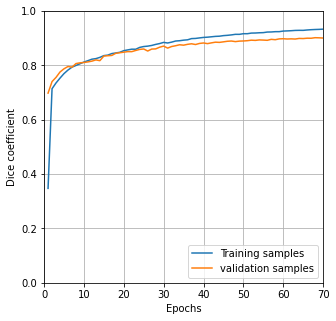

In [23]:
plt.plot(np.arange(1,71),train)
plt.plot(np.arange(1,71),test)
plt.xlabel('Epochs')
plt.ylabel('Dice coefficient')
#plt.xscale('log')
plt.xlim(0,70)
plt.ylim(0,1)
plt.grid()
plt.legend(['Training samples','validation samples'], loc='lower right')
plt.savefig('filename.png')
plt.show()

# Predict

In [1]:
model = get_unet()
model.load_weights('weights1/3D-Unet.h5')

NameError: name 'get_unet' is not defined

In [25]:
file_count =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/lungs_boxed/**')

In [26]:
for file in file_count[0:100]:
    lungs = np.load(file)['arr_0']
    X = lungs.shape[0]
    Y = lungs.shape[1]
    Z = lungs.shape[2]
    prediction = np.zeros((Z,X,Y))
    lungs = np.swapaxes(lungs, 2, 0)
    lungs = np.swapaxes(lungs, 2, 1)
    lungs = np.expand_dims(lungs, axis=4)
    lungs = np.expand_dims(lungs, axis=0)
    for z in range(0,Z-16,4):
        for y in range(0,Y-64,16):
            for x in range(0,X-64,16):
                
                prediction[z:z+16,x:x+64,y:y+64] += model.predict(lungs[:,z:z+16,x:x+64,y:y+64,:], batch_size=1, verbose=0)[0,:,:,:,0]
                
    i = file.split('/')[-1][:-4]
    print(i)
    prediction = prediction/prediction.max()
    np.savez_compressed('/media/HDD2TB_2/nathan/segmented_lungs/64_dense/'+str(i), prediction)

/home/nathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


372
654
456
46
93
657
893
233
380
829
32
713
281
966
617
496
504
134
674
690
499
433
7
260
673
880
849
570
196
131
100
844
73
309
182
284
788
454
358
307
60
213
319
498
508
951
701
243
766
88
241
287
873
530
720
517
896
809
98
217
672
724
622
884
760
482
612
411
989
322
11
49
349
191
162
228
61
953
336
761
691
793
515
544
752
604
78
746
39
376
452
126
146
700
410
219
489
586
201
393


# Evaluate

In [79]:
trues =  glob.glob('/media/HDD2TB_2/nathan/seg+nods/**')
#preds1 =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/64_Predictions/**')
#preds2 =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/32_Predictions/**')
lungs =  glob.glob('/media/HDD2TB_2/nathan/clean_scans/**')

true = np.load('/media/HDD2TB_2/nathan/nodules/184.npz')['arr_0']
lung = np.load('/media/HDD2TB_2/nathan/clean_scans/184.npz')['arr_0']

In [80]:
print(true.shape, lung.shape)

(512, 512, 140) (512, 512, 140)


In [81]:
#pred = np.swapaxes(pred, 2, 0)
#pred = np.swapaxes(pred, 2, 1)

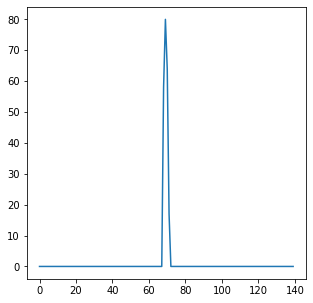

In [82]:
plt.plot(np.sum(np.sum(true, axis=0,), axis=0))

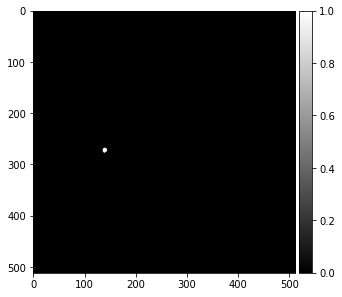

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
z = 70
plt.figure()
ax = plt.gca()
im = ax.imshow(true[:,:,z], cmap='gray')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.savefig('1.png')
plt.colorbar(im, cax=cax)

In [ ]:
sens = (pred>0.05).astype(int)

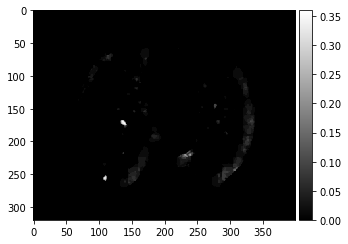

In [92]:
plt.figure()
ax = plt.gca()
im = ax.imshow(pred[:,:,z], cmap='gray')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.savefig('2.png')
plt.colorbar(im, cax=cax)

In [14]:
trues =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/nods_boxed/**')
preds =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/64_Predictions/**')
lungs =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/lungs_boxed/**')
fprs =  glob.glob('/media/HDD2TB_2/nathan/segmented_lungs/32_pred_quadruple/**')

In [15]:
thr = np.arange(0,1.05,0.05)

TP = np.zeros(21)
FP = np.zeros(21)
TN = np.zeros(21)
FN = np.zeros(21)

dsc = []

for i in range(0,100):
    print(i)
    true = np.load(trues[i])['arr_0']
    pred = np.load(preds[i])['arr_0']
    
    fpr = np.load(fprs[i])['arr_0']
    
    pred = np.swapaxes(pred, 2, 0)
    pred = np.swapaxes(pred, 2, 1)
    
    #fpr = np.swapaxes(fpr, 2, 1)
    #fpr = np.swapaxes(fpr, 2, 0)
    
    #pred = np.power(fpr, 1/8)*pred
    
    for th in thr:
        tr_pred = (pred>th).astype(float)
        
        tp = (tr_pred*true).sum()
        fp = tr_pred.sum() - tp
        fn = true.sum() - tp
        tn = true.shape[0]*true.shape[1]*true.shape[2] - tp - fp - fn
        
        TP[int(th*20)] += tp
        FP[int(th*20)] += fp
        TN[int(th*20)] += tn
        FN[int(th*20)] += fn
        
TPR = TP/(TP+FN)
DSC = 2*TP/(2*TP+FP+FN)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


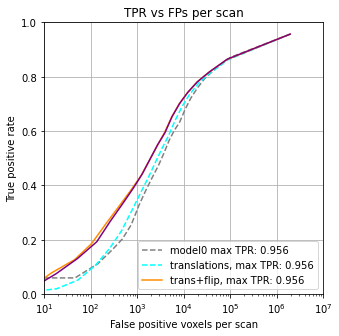

In [228]:
#plt.scatter(FP1/100,TPR1)
plt.plot(FP1/100,TPR1,'--',color='gray')
#plt.scatter(FP_3/10,TPR_3)
plt.plot(FP2/100,TPR2,'--',color='cyan')
plt.plot(FPt/100,TPRt, color='darkorange')
plt.plot(FPtr/100,TPRtr, color='purple')
#plt.scatter(FP_5/10,TPR_5)

#plt.plot(FP5/100,TPR5, color='red')
#plt.plot(FP10/100,TPR10, color='blue')
#plt.scatter(FP_7/10,TPR_7)
plt.xlabel('False positive voxels per scan')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(10,10000000)
plt.xscale('log')
plt.legend(['model0 max TPR: '+ str(TPR1[0])[:5],'translations, max TPR: '+ str(TPR2[0])[:5]
           , 'trans+flip, max TPR: '+ str(TPR3[0])[:5]])
plt.grid()
plt.title('TPR vs FPs per scan')
plt.savefig('plot1')
plt.show()

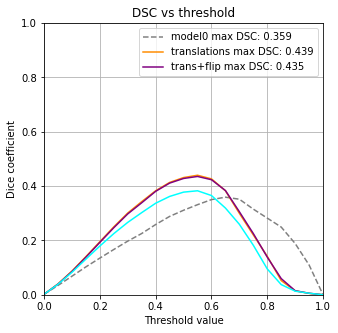

In [230]:
plt.plot(thr,DSC1,'--',color='gray')
#plt.scatter(thr,DSC)
plt.plot(thr,DSCt,color='darkorange')
#plt.plot(thr,DSC5,color='red')
plt.plot(thr,DSCtr, color='purple')
#plt.scatter(thr,DSC)
plt.plot(thr,DSC2, color='cyan')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('Threshold value')
plt.ylabel('Dice coefficient')
plt.legend(['model0 max DSC: '+ str(np.max(DSC1))[:5], 'translations max DSC: '+ str(np.max(DSCt))[:5]
           , 'trans+flip max DSC: '+ str(np.max(DSCtr))[:5]])
plt.grid()
plt.title('DSC vs threshold')
plt.savefig('plot2')
plt.show()

In [225]:
FP1 = FP
DSC1 = DSC
TPR1 = TPR

In [197]:
FP2 = FP
DSC2 = DSC
TPR2 = TPR

In [217]:
FPt = FP
DSCt = DSC
TPRt = TPR

In [16]:
FPtr = FP
DSCtr = DSC
TPRtr = TPR